In [32]:
from __future__ import division, print_function
import numpy as np
from hmmlearn.hmm import MultinomialHMM
import poetrytools
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
%run 'preprocessing.ipynb'

In [4]:
def get_rhymes(words):
    num_words = len(words)
    rhymes = np.empty((num_words, num_words))
    
    for i in range(num_words):
        for j in (k for k in range(num_words) if not k == i):
            if poetrytools.rhymes(words[i], words[j]):
                rhymes[i][j] = 1
    return rhymes

In [5]:
quatrain_rhymes = get_rhymes(quatrain_words)
volta_rhymes = get_rhymes(volta_words)
couplet_rhymes = get_rhymes(couplet_words)

In [6]:
reversed_quatrain_model = MultinomialHMM(n_components=5, n_iter=20, verbose=True);
reversed_volta_model = MultinomialHMM(n_components=5, n_iter=20, verbose=True);
reversed_couplet_model = MultinomialHMM(n_components=5, n_iter=20, verbose=True);
reversed_quatrain_model.fit(np.concatenate(reversed_converted_quatrain_lines), quatrain_lengths);
reversed_volta_model.fit(np.concatenate(reversed_converted_volta_lines), volta_lengths);
reversed_couplet_model.fit(np.concatenate(reversed_converted_couplet_lines), couplet_lengths);

         1      -76070.9961             +nan
         2      -62168.1133      +13902.8828
         3      -62160.0255          +8.0878
         4      -62138.8658         +21.1597
         5      -62087.8620         +51.0038
         6      -61984.4888        +103.3732
         7      -61814.7796        +169.7092
         8      -61555.5003        +259.2793
         9      -61168.1184        +387.3819
        10      -60708.6316        +459.4868
        11      -60308.3655        +400.2661
        12      -60040.2130        +268.1526
        13      -59885.6077        +154.6052
        14      -59778.0793        +107.5284
        15      -59667.2122        +110.8671
        16      -59531.9324        +135.2798
        17      -59365.8502        +166.0822
        18      -59170.3448        +195.5054
        19      -58950.8938        +219.4510
        20      -58717.6559        +233.2379
         1      -36039.4626             +nan
         2      -30166.2873       +5873.1753
         3

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=5,
        n_iter=20, params='ste',
        random_state=<mtrand.RandomState object at 0x10c5dd690>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)

In [115]:
# get the top 10 connected words for 5 hidden states for quatrain, volta, and couplet words 
def top_words(model, words, name): 
    total = []
    for j in range(5):
        top_ten = np.argsort(np.array(model.emissionprob_[j]))[::-1][:10]
        sub = [words[i] for i in top_ten]
        total.append(sub)

    print("\n", name)
    for j in range(10):
        print(' & '.join([i[j] for i in total]), "\\" + "\\")

top_words(reversed_quatrain_model, quatrain_words, "Quatrain")
top_words(reversed_volta_model, volta_words, "Volta")
top_words(reversed_couplet_model, couplet_words, "Couplet")


 Quatrain
that & a & thee & and & of \\
your & that & sight & that & to \\
my & when & heart & is & the \\
me & i & me & i & and \\
the & the & eyes & which & in \\
be & for & time & thy & my \\
is & love & love & so & thou \\
his & all & eye & as & i \\
thy & his & still & thou & with \\
love & me & alone & my & thy \\

 Volta
and & to & that & thee & my \\
i & of & love & be & the \\
not & in & and & me & thy \\
the & with & me & state & be \\
thou & for & but & more & a \\
in & thy & self & night & his \\
thy & doth & eyes & decay & and \\
which & or & of & day & thee \\
that & that & all & true & so \\
so & the & how & part & your \\

 Couplet
my & and & me & i & of \\
thy & thou & thee & and & thee \\
in & that & be & this & and \\
to & for & days & but & so \\
is & in & praise & to & with \\
i & love & so & the & all \\
it & my & dead & for & me \\
of & not & mind & that & such \\
a & i & woe & as & dost \\
be & to & heart & my & love \\


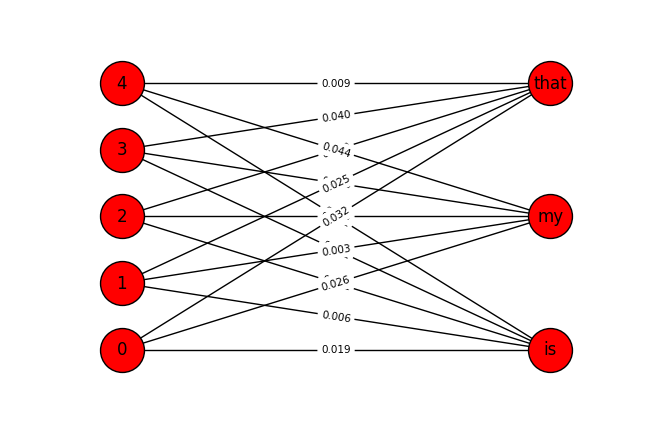

In [312]:
# add bipartite graph of states and words
matrix = reversed_quatrain_model.emissionprob_
(n,m) = matrix.shape

# top 10 highest probability words out of all 5 hidden states
b = np.dstack(np.unravel_index(np.argsort(matrix.ravel()), matrix.shape))[0]
b = b[-10:,1]
_, idx = np.unique(b, return_index=True)
top_ten = b[np.sort(idx)][:3]
top_ten_names = [quatrain_words[i] for i in top_ten]

# add graph
G = nx.Graph()
G.add_nodes_from(range(5), bipartite=0)
G.add_nodes_from(top_ten_names, bipartite=1)

# add edge and weights
for i in range(n):
    for j in range(len(top_ten_names)):
        G.add_edge(i, top_ten_names[j], weight= matrix[i,top_ten[j]])

# Separate by group
l, r = nx.bipartite.sets(G)
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index*2)) for index, node in enumerate(r))

# draw graph
edges=dict([((a, b), '%.3f'%(d['weight'])) for a, b, d in G.edges(data=True)])
nx.draw(G, pos, with_labels=True, node_size=1000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges, font_size=7.5)
plt.savefig('emission_visual.png')
plt.show()


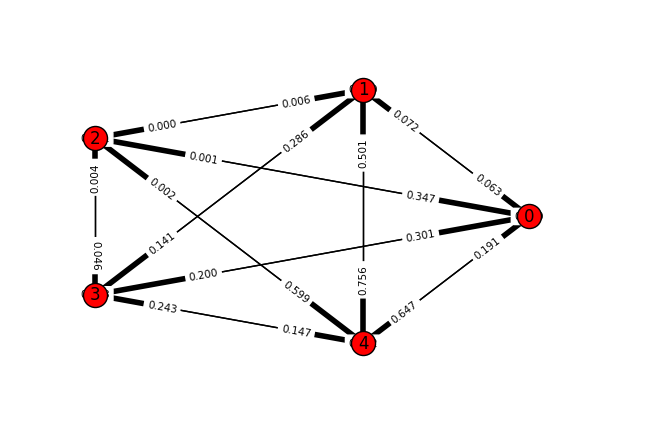

In [313]:
# directed graph for transition matrix
matrix = reversed_quatrain_model.transmat_

# add graph
(n,m) = matrix.shape
G = nx.DiGraph()
G.add_nodes_from(range(n))

# add edge and weights
for i in range(n):
    for j in range(n):
        G.add_edge(i, j, weight= matrix[i,j])

# draw graph
edges=dict([((a, b), '%.3f'%(d['weight'])) for a, b, d in G.edges(data=True)])
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges, label_pos=0.25, font_size=7.5)
plt.savefig('transition_visual.png')
plt.show()